In [ ]:
#CLEANED

import numpy as np
import os
import matplotlib.pyplot as plt

import helper

/gpfs1/home/c/p/cpetak/Variability_of_Evolvability/helper.py:165: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/gpfs1/home/c/p/cpetak/Variability_of_Evolvability/helper.py:186: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [2]:
root="~/CA_GRN_results/detailed_save/"
metric1 = "beststd"
metric2 = "best_grn_std"
num_reps = 15
season_len=300
id_start = 0
seed_ints = [69904,149796]
grn_size = 22

rules = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]
rules = [54] #22,54,102 pretty high, 126,122,70,150 low, 154,18,94,30,62,110,90 medium

for rule in rules:
    print(rule)
    std_vals=[np.loadtxt(os.path.expanduser(root+f"variable/stats_{season_len}_{rule}-{rule}_69904-149796_{i+1+id_start}_{metric1}.txt")) for i in range(num_reps)]
    std_vals = np.array(std_vals)
    print(std_vals.shape)

for rule in rules:
    print(rule)
    std_grns=[np.loadtxt(os.path.expanduser(root+f"variable/stats_{season_len}_{rule}-{rule}_69904-149796_{i+1+id_start}_{metric2}.txt")) for i in range(num_reps)]
    std_grns = np.array(std_grns)
    std_grns = np.reshape(std_grns, (num_reps, 9898,grn_size+2,grn_size))
    print(std_grns.shape)

54
(15, 9898)
54
(15, 9898, 24, 22)


In [3]:
def make_heatmap(rep, gen):
    grn_to_test = std_grns[rep, gen, :, :]

    #create pop of kids
    num_clones = 10_000
    seasons = np.tile(np.repeat([0, 1], 300), 100)
    kids = np.repeat(grn_to_test[np.newaxis, :, :], num_clones, axis=0)

    #mutate all
    mut_rate = 0.1
    mut_size = 0.5
    num_genes_mutate = int((grn_size + 2) * grn_size * num_clones * mut_rate)
    np.random.seed(44)
    mutations = np.random.randn(num_genes_mutate) * mut_size
    x, y, z = kids.shape
    xs = np.random.choice(x, size=num_genes_mutate)
    ys = np.random.choice(y, size=num_genes_mutate)
    zs = np.random.choice(z, size=num_genes_mutate)
    kids[xs, ys, zs] = kids[xs, ys, zs] + mutations

    #calc phenos
    num_cells = 22
    dev_steps = 22
    inputs = []
    seeds = []
    for seed_int in seed_ints:
        #Make seeds, 1024 is one-hot
        start_pattern = helper.seedID2string(seed_int, num_cells)
        seeds.append(start_pattern)
        start_expression = helper.seed2expression(start_pattern, num_clones, num_cells, grn_size, geneid=1)
        inputs.append(start_expression)

    targets = []
    for idx, seed in enumerate(seeds):
        targets.append(helper.rule2targets_wrapped_wstart(int(rule), L=dev_steps+1, N=num_cells, start_pattern=seed))

    #parent pheno
    curr = seasons[gen]
    print(curr)
    parent_pheno = helper.develop(inputs[curr], np.expand_dims(grn_to_test, axis=0), dev_steps, 1, grn_size, num_cells)

    #kids pheno
    phenos = helper.develop(inputs[curr], kids, dev_steps, num_clones, grn_size, num_cells)
    #print(kids.shape, phenos.shape)
    p=phenos[:,:,1::grn_size]
    #print(p.shape)
    per_cell_std = np.std(p, axis = 0)
    fitnesses1 = helper.fitness_function_ca(p, targets[0])
    fitnesses2 = helper.fitness_function_ca(p, targets[1])
    worst= -num_cells*dev_steps
    fitnesses1=1-(fitnesses1/worst)
    fitnesses2=1-(fitnesses2/worst)

    parent_fit1 = helper.fitness_function_ca(parent_pheno[:,:,1::grn_size], targets[0])
    parent_fit2 = helper.fitness_function_ca(parent_pheno[:,:,1::grn_size], targets[1])
    parent_fit1=1-(parent_fit1/worst)
    parent_fit2=1-(parent_fit2/worst)

    #get pheno variation
    where_overlap = np.where(targets[0]==targets[1])
    where_no_overlap = np.where(targets[0]!=targets[1])

    values_they_should_match = p[:,where_overlap[0],where_overlap[1]]
    matching_std = np.std(values_they_should_match, axis=0)
    matching_std = matching_std.mean(axis=0) #average across the N overlaps, to get 1 value for each parent
    #print(matching_std)

    #repeat for non-overlap
    values_they_shouldnt_match = p[:,where_no_overlap[0],where_no_overlap[1]]
    nonmatching_std = np.std(values_they_shouldnt_match, axis=0)
    nonmatching_std = nonmatching_std.mean(axis=0)
    #print(nonmatching_std)

    #minimum std is 0, max is 0.5 in the case of values that range between 0 and 1
    combined_std = nonmatching_std - matching_std
    
    return parent_pheno, per_cell_std, combined_std, targets, fitnesses1, fitnesses2, parent_fit1, parent_fit2


In [4]:
rep, gen = np.unravel_index(np.argmax(std_vals), std_vals.shape)

In [5]:
flat_indices = np.argsort(std_vals, axis=None)  # Get the indices of the top 10 values

# Convert the flat indices to 2D coordinates (row, column)
top_coords = np.unravel_index(flat_indices, std_vals.shape)

rep = top_coords[0][-1]
gen = top_coords[1][-1]

rep, gen

(10, 8702)

In [6]:
cstds=[]
for g in [gen]:
    parent_pheno, per_cell_std, combined_std, targets,f1,f2,pf1,pf2 = make_heatmap(rep, g)
    cstds.append(combined_std)


1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


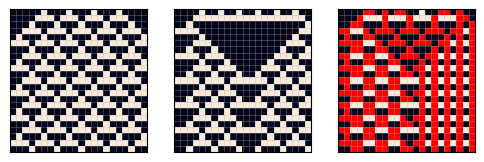

In [7]:
import seaborn as sns
from matplotlib.lines import Line2D

fig, axs = plt.subplots(ncols=3, figsize=(6, 4))

preds = np.where(targets[0] > 0.5, 1, 0)
correct = np.where(np.abs(targets[1] - preds) > 0, 1, 0)
correct_mask = np.ma.array(targets[1], mask=correct)
reds = np.dstack(
    [np.ones_like(targets[1]) * 255, np.zeros_like(targets[1]), np.zeros_like(targets[1])]
)

# Create the figure
axs[2].imshow(reds, label="errors")  # red background
#plt.imshow(correct_mask)

# a bit of a mindfuck, correct is used as a mask so it's like the inverse... xD
error_perc = correct.sum() / targets[1].size * 100

helper.imshow_ca(targets[0], ax=axs[0])
helper.imshow_ca(targets[1], ax=axs[1])
helper.imshow_ca(correct_mask, ax=axs[2])


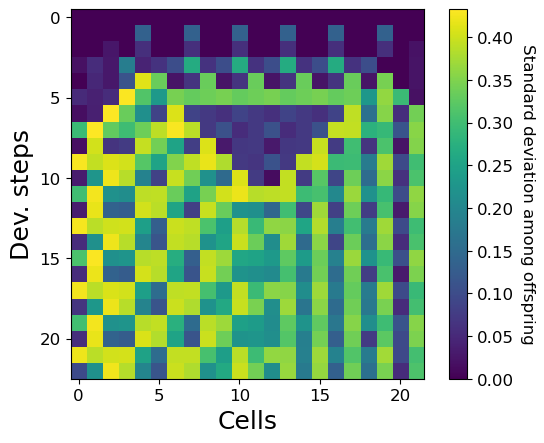

In [8]:
plt.imshow(per_cell_std)
cbar=plt.colorbar()
plt.xlabel("Cells", fontsize=18)
plt.ylabel("Dev. steps", fontsize=18)
#plt.legend(loc="upper right", prop={'size': 18})
plt.tick_params(axis='both', which='major', labelsize=12)
cbar.set_label('Standard deviation among offspring', fontsize=12)
cbar.ax.yaxis.label.set_rotation(270)  # Rotate label to the left
cbar.ax.yaxis.label.set_horizontalalignment('center')  # Align horizontally
cbar.ax.yaxis.label.set_verticalalignment('bottom')  # Align vertically
cbar.ax.tick_params(labelsize=12)
plt.show()